# Risk prediction using regression

Train a regression model on the first half of the data, use it to predict risk of infection on the second half.

NOT FINISHED!

In [35]:
import os
from os import path

from datetime import datetime
import pytz

import pickle

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

import networkx as nx

from utils.parsing import get_contact_list, get_infection_list, get_node_state

In [36]:
data_folder = "./data"
output_folder = "./output"
if not path.exists(output_folder):
    os.makedirs(output_folder)

sim_id = 156
print_data_warnings = False
discard_reinfections = True
def_contact_time = 10
time_step_min = 30
time_delta_sec = 60 * time_step_min

sim_tz = "Asia/Shanghai"
time0 = 'Nov 20 2023 9:00AM'
time1 = 'Dec 4 2023 12:00PM'
timezone = pytz.timezone(sim_tz)
obs_date0 = timezone.localize(datetime.strptime(time0, '%b %d %Y %I:%M%p'))
obs_date1 = timezone.localize(datetime.strptime(time1, '%b %d %Y %I:%M%p'))

In [37]:
all_users = pd.read_csv(path.join(data_folder, "participants.csv"), low_memory=False) 
all_events = pd.read_csv(path.join(data_folder, "histories.csv"), low_memory=False)
users = all_users[all_users["sim_id"] == sim_id]
users['random_id'] = users['random_id'].astype(str).str.zfill(4)
events = all_events[all_events["sim_id"] == sim_id]
events.fillna({'contact_length':0, 'peer_id':-1}, inplace=True)
events["event_start"] = events["time"] - events["contact_length"]/1000
events["event_start"] = events["event_start"].astype(int)

p2pToSim = pd.Series(users.sim_id.values, index=users.p2p_id).to_dict()
p2pToId = pd.Series(users.id.values, index=users.p2p_id).to_dict()
idTop2p = pd.Series(users.p2p_id.values, index=users.id).to_dict()
        
user_index = {}
index_user = {}
idx = 0
for kid in idTop2p:
    user_index[kid] = idx
    index_user[idx] = kid
    idx += 1

/var/folders/4g/z3rj5j_j781_8ckvkcy7p4840000gp/T/ipykernel_79621/1188551509.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  events.fillna({'contact_length':0, 'peer_id':-1}, inplace=True)


In [38]:
state = get_node_state(user_index, events, None, print_data_warnings)
infections = get_infection_list(user_index, events, True, time_delta_sec)
contacts = get_contact_list(user_index, events, infections, def_contact_time, print_data_warnings)

In [39]:
with open(path.join(data_folder, 'network-largest_conn_comp.pickle'), 'rb') as f:
    G = pickle.load(f)

In [40]:
tmin = datetime.timestamp(obs_date0)
tmax = datetime.timestamp(obs_date1)

# Time delta for plots in seconds, each frame is 1 day
daily_delta_sec = 60 * (60 * 24)

t = tmin
frame = 0

tstate = None
print('Calculating the network for each day of the sim...')
nodes0 = list(G.nodes()) # We only look at the nodes we already selected before (which have enough interactions over the entire period of the sim)
allgs = np.zeros((15, len(nodes0), len(nodes0)))
while t <= tmax:
    t0 = t
    t += daily_delta_sec
    td = datetime.fromtimestamp(t, tz=timezone)
    print('Frame', frame+1, datetime.fromtimestamp(t0, tz=timezone).strftime('%Y-%m-%d %H:%M'), 'to', td.strftime('%Y-%m-%d %H:%M'))
    
    # We want to include contact and infection events that either started or ended between t0 and t
    condition = ((t0 < events['event_start']) & (events['event_start'] <= t)) | ((t0 < events['time']) & (events['time'] <= t))
    tevents = events[condition]
    tstate = get_node_state(user_index, tevents, tstate, False)
    tinf = get_infection_list(user_index, tevents, discard_reinfections, time_delta_sec)
    tcontacts = get_contact_list(user_index, tevents, tinf, def_contact_time, False)

    tg = nx.Graph()
    tg.add_nodes_from(nodes0)
    tedges = []
    tweights = []
    if 0 < len(tcontacts):
        for p in tcontacts:
            n0 = p[0]
            n1 = p[1]
            w = tcontacts[p]            
            if n0 in nodes0 and n1 in nodes0 and 0 < w:
                tedges += [(n0, n1)]
                tweights += [w]

    # Get average degree of susceptible node i over the last x days, and retrieve the final infectious state (0/1) - this is x and y for the model
    
    frame += 1
print('Done')

Calculating the network for each day of the sim...
Frame 1 2023-11-20 09:00 to 2023-11-21 09:00
Frame 2 2023-11-21 09:00 to 2023-11-22 09:00
Frame 3 2023-11-22 09:00 to 2023-11-23 09:00
Frame 4 2023-11-23 09:00 to 2023-11-24 09:00
Frame 5 2023-11-24 09:00 to 2023-11-25 09:00
Frame 6 2023-11-25 09:00 to 2023-11-26 09:00
Frame 7 2023-11-26 09:00 to 2023-11-27 09:00
Frame 8 2023-11-27 09:00 to 2023-11-28 09:00
Frame 9 2023-11-28 09:00 to 2023-11-29 09:00
Frame 10 2023-11-29 09:00 to 2023-11-30 09:00
Frame 11 2023-11-30 09:00 to 2023-12-01 09:00
Frame 12 2023-12-01 09:00 to 2023-12-02 09:00
Frame 13 2023-12-02 09:00 to 2023-12-03 09:00
Frame 14 2023-12-03 09:00 to 2023-12-04 09:00
Frame 15 2023-12-04 09:00 to 2023-12-05 09:00
Done


In [2]:
x = np.arange(10).reshape(-1, 1)
y = np.array([0, 0, 0, 0, 1, 1, 1, 1, 1, 1])

In [3]:
model = LogisticRegression(solver='liblinear', random_state=0)

In [4]:
model.fit(x, y)

LogisticRegression(random_state=0, solver='liblinear')

In [6]:
model.predict(x)

array([0, 0, 0, 1, 1, 1, 1, 1, 1, 1])

In [7]:
model.score(x, y)

0.9

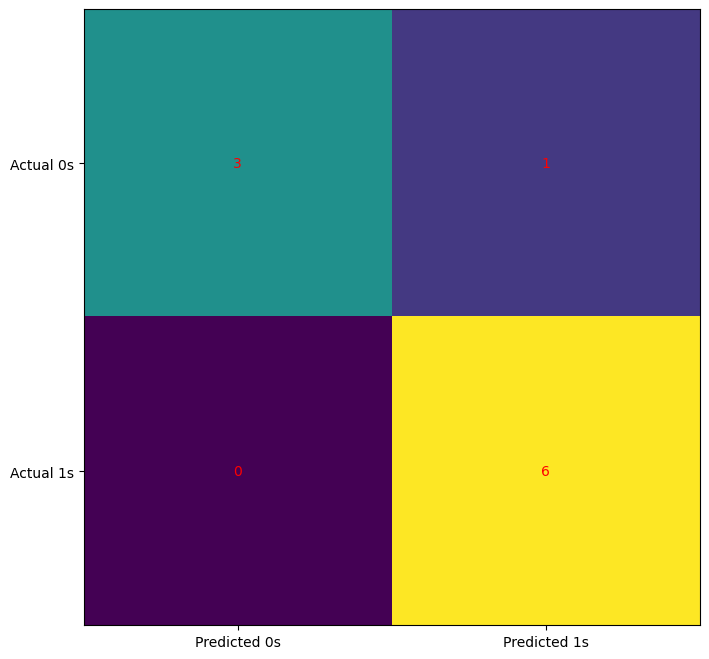

In [8]:
cm = confusion_matrix(y, model.predict(x))

fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(cm)
ax.grid(False)
ax.xaxis.set(ticks=(0, 1), ticklabels=('Predicted 0s', 'Predicted 1s'))
ax.yaxis.set(ticks=(0, 1), ticklabels=('Actual 0s', 'Actual 1s'))
ax.set_ylim(1.5, -0.5)
for i in range(2):
    for j in range(2):
        ax.text(j, i, cm[i, j], ha='center', va='center', color='red')
plt.show()

In [9]:
print(classification_report(y, model.predict(x)))

              precision    recall  f1-score   support

           0       1.00      0.75      0.86         4
           1       0.86      1.00      0.92         6

    accuracy                           0.90        10
   macro avg       0.93      0.88      0.89        10
weighted avg       0.91      0.90      0.90        10

